"developed by : __*aipythoner@gmail.com*__"

__idea came from :__  
[Accurate Retinal Vessel Segmentation viaOctave Convolution Neural Network](https://arxiv.org/pdf/1906.12193.pdf)

__UNet Network :__  
[U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)

In [1]:
import cv2, glob, os, warnings; warnings.simplefilter('ignore')
from tensorflow.keras.layers import Conv2D, AvgPool2D, Dropout, Input, BatchNormalization, AveragePooling2D, Add
from tensorflow.keras.layers import Cropping2D, UpSampling2D, Conv2DTranspose, concatenate, Concatenate, Lambda
from tensorflow.keras.models import Model
from PIL import Image, ImageSequence
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
from oct_conv2d import OctConv2D, OctConv2DTranspose
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


### Use U-Net Paper Dataset

In [2]:
num_classes = 1
IMG_SIZE = (512, 512)

In [3]:
# Just some copy paste if you have time clean it

def tiff_to_png(file_path):
    tiff_file = Image.open(file_path)
    if "train" in file_path:
        if "label" in file_path:
            TRAIN_PATH = './dataset/train_labels/'
            if os.path.exists(TRAIN_PATH):
                for idx, image in enumerate(ImageSequence.Iterator(tiff_file)):
                    image_path = TRAIN_PATH + str(idx) + '.png'
                    image = cv2.resize(np.array(image), IMG_SIZE, interpolation = cv2.INTER_AREA)
                    cv2.imwrite(image_path, np.array(image))
            else:
                os.makedirs(TRAIN_PATH)
                for idx, image in enumerate(ImageSequence.Iterator(tiff_file)):
                    image_path = TRAIN_PATH + str(idx) + '.png'
                    image = cv2.resize(np.array(image), IMG_SIZE, interpolation = cv2.INTER_AREA)
                    cv2.imwrite(image_path, np.array(image))
              
        else:
            TRAIN_PATH = './dataset/train_imgs/'
            if os.path.exists(TRAIN_PATH):
                for idx, image in enumerate(ImageSequence.Iterator(tiff_file)):
                    image_path = TRAIN_PATH + str(idx) + '.png'
                    image = cv2.resize(np.array(image), IMG_SIZE, interpolation = cv2.INTER_AREA)
                    cv2.imwrite(image_path, np.array(image))
                    
            else:
                os.makedirs(TRAIN_PATH)
                for idx, image in enumerate(ImageSequence.Iterator(tiff_file)):
                    image_path = TRAIN_PATH + str(idx) + '.png'
                    image = cv2.resize(np.array(image), IMG_SIZE, interpolation = cv2.INTER_AREA)
                    cv2.imwrite(image_path, np.array(image))
                
    elif "valid" in file_path:
        if "label" in file_path:
            VALID_PATH = './dataset/valid_labels/'
            if os.path.exists(VALID_PATH):
                for idx, image in enumerate(ImageSequence.Iterator(tiff_file)):
                    image_path = VALID_PATH + str(idx) + '.png'
                    image = cv2.resize(np.array(image), IMG_SIZE, interpolation = cv2.INTER_AREA)
                    cv2.imwrite(image_path, np.array(image))
            else:
                os.makedirs(VALID_PATH)
                for idx, image in enumerate(ImageSequence.Iterator(tiff_file)):
                    image_path = VALID_PATH + str(idx) + '.png'
                    image = cv2.resize(np.array(image), IMG_SIZE, interpolation = cv2.INTER_AREA)
                    cv2.imwrite(image_path, np.array(image))
            
        else:
            VALID_PATH = './dataset/valid_imgs/'
            if os.path.exists(VALID_PATH):
                for idx, image in enumerate(ImageSequence.Iterator(tiff_file)):
                    image_path = VALID_PATH + str(idx) + '.png'
                    image = cv2.resize(np.array(image), IMG_SIZE, interpolation = cv2.INTER_AREA)
                    cv2.imwrite(image_path, np.array(image))
            else:
                os.makedirs(VALID_PATH)
                for idx, image in enumerate(ImageSequence.Iterator(tiff_file)):
                    image_path = VALID_PATH + str(idx) + '.png'
                    image = cv2.resize(np.array(image), IMG_SIZE, interpolation = cv2.INTER_AREA)
                    cv2.imwrite(image_path, np.array(image))
                    
    elif "test" in file_path:
        if "label" in file_path:
            TEST_PATH = './dataset/test_labels/'
            if os.path.exists(TEST_PATH):
                for idx, image in enumerate(ImageSequence.Iterator(tiff_file)):
                    image_path = TEST_PATH + str(idx) + '.png'
                    image = cv2.resize(np.array(image), IMG_SIZE, interpolation = cv2.INTER_AREA)
                    cv2.imwrite(image_path, np.array(image))
            else:
                os.makedirs(TEST_PATH)
                for idx, image in enumerate(ImageSequence.Iterator(tiff_file)):
                    image_path = TEST_PATH + str(idx) + '.png'
                    image = cv2.resize(np.array(image), IMG_SIZE, interpolation = cv2.INTER_AREA)
                    cv2.imwrite(image_path, np.array(image))
            
        else:
            TEST_PATH = './dataset/test_imgs/'
            if os.path.exists(TEST_PATH):
                for idx, image in enumerate(ImageSequence.Iterator(tiff_file)):
                    image_path = TEST_PATH + str(idx) + '.png'
                    image = cv2.resize(np.array(image), IMG_SIZE, interpolation = cv2.INTER_AREA)
                    cv2.imwrite(image_path, np.array(image))
            else:
                os.makedirs(TEST_PATH)
                for idx, image in enumerate(ImageSequence.Iterator(tiff_file)):
                    image_path = TEST_PATH + str(idx) + '.png'
                    image = cv2.resize(np.array(image), IMG_SIZE, interpolation = cv2.INTER_AREA)
                    cv2.imwrite(image_path, np.array(image))
                    
    return "Done"

tiff_to_png('../Segmentation/001_U_Net/train-volume.tif')
tiff_to_png('../Segmentation/001_U_Net/train-labels.tif')
tiff_to_png('../Segmentation/001_U_Net/test-volume.tif')

'Done'

In [4]:
labels = glob.glob('./dataset/train_labels/*.png')
datas = glob.glob("./dataset/train_imgs/*.png")

In [5]:
images = []
masks = []
for image, mask in zip(datas, labels):
    
    images.append(np.array(Image.open(image).resize(IMG_SIZE)))
    masks.append(np.array(Image.open(mask).resize(IMG_SIZE)))
    
images = np.array(images)
masks = np.array(masks)

print(images.shape, masks.shape)

(30, 512, 512) (30, 512, 512)


In [6]:
images = images.reshape(images.shape + (1,))
masks = masks.reshape(masks.shape + (1,))

images = images/255.0
masks = masks/255.0

In [7]:
train_data, val_data, train_label, val_label = train_test_split(
    images, masks,test_size=0.3, random_state=0)

print("train_data: ", train_data.shape)
print("train_label: ", train_label.shape)
print("val_data: ", val_data.shape)
print("val_label: ", val_label.shape)

train_data:  (21, 512, 512, 1)
train_label:  (21, 512, 512, 1)
val_data:  (9, 512, 512, 1)
val_label:  (9, 512, 512, 1)


In [8]:
def augment_image(train_data, trian_label, val_data= None, val_label= None, batch_size=32,
                 seed=42, datagen_args= dict(rotation_range=15., width_shift_range=0.05,
                                            height_shift_range=0.05, shear_range=0.09,
                                            zoom_range=0.02, horizontal_flip=True, 
                                            vertical_flip=True, fill_mode='constant')):
    
    train_data_datagen = ImageDataGenerator(**datagen_args)
    train_label_datagen = ImageDataGenerator(**datagen_args)
    
    train_data_datagen.fit(train_data, augment=True, seed=seed)
    train_label_datagen.fit(train_label, augment=True, seed=seed)
    
    train_data_augmented = train_data_datagen.flow(train_data, batch_size=batch_size,
                                                  shuffle=True, seed=seed)
    train_label_augmented = train_label_datagen.flow(train_label, batch_size=batch_size,
                                                    shuffle=True, seed=seed)
    
    train_generator = zip(train_data_augmented, train_label_augmented)
    
    if (val_data!= None) and (val_label!= None):
        valid_data_datagen = ImageDataGenerator(**datagen_args)
        valid_label_datagen = ImageDataGenerator(**datagen_args)

        valid_data_datagen.fit(valid_data, augment=True, seed=seed)
        valid_label_datagen.fit(valid_label, augment=True, seed=seed)

        valid_data_augmented = valid_data_datagen.flow(valid_data, batch_size=batch_size,
                                                      shuffle=True, seed=seed)
        valid_label_augmented = valid_label_datagen.flow(valid_label, batch_size=batch_size,
                                                        shuffle=True, seed=seed)
        
        valid_generator = zip(valid_data_augmented, valid_label_augmented)
        
        return train_generator, valid_generator
    
    else:
        return train_generator

In [9]:
train_gen = augment_image(
    train_data, train_label, batch_size=2,
    datagen_args= dict(
        rotation_range=15.,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=50,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))

In [10]:
def contract_conv(input_x, filters, alpha, pad='same'):
    high, low = input_x
    high, low  = OctConv2D(filters, alpha,(3,3), padding=pad)([high, low])
    high = BatchNormalization()(high)
    low = BatchNormalization()(low)
    high = Dropout(0.3)(high)
    low = Dropout(0.3)(low)
    high, low = OctConv2D(filters, alpha,(3,3), padding=pad)([high, low])
    high = BatchNormalization()(high)
    low = BatchNormalization()(low)
    return [high, low]

In [11]:
filters, num_layers= 64, 4
input_layer = Input((512, 512, 1))
low = AvgPool2D((2,2))(input_layer)

In [12]:
unet_layers = [input_layer, low]
alpha = [0.5, 0.5, 0.25, 0.25]
conv_layers = []
for l in range(num_layers):
    unet_layers = contract_conv(unet_layers, filters=filters, alpha=alpha[l])
    conv_layers.append(unet_layers)
    unet_layers[0] = AveragePooling2D(2)(unet_layers[0])
    unet_layers[1] = AveragePooling2D(2)(unet_layers[1]) 
    filters *= 2

In [13]:
unet_layers = contract_conv(input_x=unet_layers, filters=filters, alpha=0.25,pad='same')
unet_layers[0] = AveragePooling2D(2)(unet_layers[0])
unet_layers[1] = AveragePooling2D(2)(unet_layers[1]) 

In [14]:
alpha_rev = [0.25, 0.25, 0.5, 0.5]
i = 0
for conv in reversed(conv_layers):
    filters //= 2
    unet_layers = OctConv2DTranspose(filters, alpha_rev[i],(2, 2),\
                                     strides=(2, 2), padding='same')(unet_layers)
    unet_layers[0] = concatenate([unet_layers[0], conv[0]])
    unet_layers[1] = concatenate([unet_layers[1], conv[1]])
    unet_layers = contract_conv(unet_layers, filters, alpha_rev[i])
    i+=1

In [15]:
ch_high = int(unet_layers[0].shape[-1])
h2h = Conv2DTranspose(ch_high, 3, strides=(2,2), padding='same')(unet_layers[0])
l2h = Conv2DTranspose(ch_high, 3, strides=(2,2), padding='same')(unet_layers[1])
l2h = Lambda(lambda x: K.repeat_elements(K.repeat_elements(x, 2, axis=1), 2, axis=2))(l2h)
x = Add()([h2h, l2h])
output_layer = Conv2D(num_classes, (1,1), activation='sigmoid')(x)
print(output_layer)

Tensor("conv2d/Sigmoid:0", shape=(?, 512, 512, 1), dtype=float32)


In [16]:
OctaveUNnet = Model(inputs=input_layer, outputs=output_layer)
OctaveUNnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
average_pooling2d (AveragePooli (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
oct_conv2d (OctConv2D)          [(None, 512, 512, 32 1152        input_1[0][0]                    
                                                                 average_pooling2d[0][0]          
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 512, 512, 32) 128         oct_conv2d[0][0]                 
__________

In [17]:
def iou(y_true, y_pred, smooth=1.):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    res = (intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) - intersection + smooth)
    
    return res

def iou_thresholded(y_true, y_pred, threshold=0.5, smooth=1.):
    y_pred = threshold_binarize(y_pred, threshold)
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    intersection = K.sum(y_true * y_pred)
    res = (intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) - intersection + smooth)
    
    return res

def threshold_binarize(x, threshold=0.5):
    ge = tf.greater_equal(x, tf.constant(threshold))
    y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
    return y

In [18]:
# OctaveUNnet.compile(
#     optimizer=SGD(lr=0.01, momentum=0.99),
#     loss='binary_crossentropy',
#     metrics=[iou, iou_thresholded]
# )
OctaveUNnet.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=[iou, iou_thresholded]
)

In [19]:
# Dont remove this cell, or it may not work
# Bug https://github.com/tensorflow/tensorflow/issues/32357
train_gen = (pair for pair in train_gen)

In [20]:
# hist = OctaveUNnet.fit(train_data,train_label, batch_size=16, 
#                        epochs=20, steps_per_epoch=32,
#                        validation_data=(val_data, val_label))

# Problem (Keras)  
### __* USING FIT Give OOM Error even batch_size=1 *__

In [21]:
hist = OctaveUNnet.fit_generator(train_gen, steps_per_epoch=100,\
                epochs=20, validation_data=(val_data, val_label))

Epoch 1/20
100/100 [==============================] - 39s 394ms/step - loss: 0.6649 - iou: 0.7029 - iou_thresholded: 0.7822 - val_loss: 16.4853 - val_iou: 0.0965 - val_iou_thresholded: 0.0967
Epoch 2/20
100/100 [==============================] - 21s 214ms/step - loss: 0.5896 - iou: 0.7439 - iou_thresholded: 0.8096 - val_loss: 1.3584 - val_iou: 0.4778 - val_iou_thresholded: 0.4928
Epoch 3/20
100/100 [==============================] - 21s 213ms/step - loss: 0.5982 - iou: 0.7451 - iou_thresholded: 0.8101 - val_loss: 0.6901 - val_iou: 0.7570 - val_iou_thresholded: 0.7987
Epoch 4/20
100/100 [==============================] - 21s 212ms/step - loss: 0.5920 - iou: 0.7451 - iou_thresholded: 0.8104 - val_loss: 0.5949 - val_iou: 0.7571 - val_iou_thresholded: 0.8287
Epoch 5/20
100/100 [==============================] - 21s 214ms/step - loss: 0.5976 - iou: 0.7455 - iou_thresholded: 0.8107 - val_loss: 0.6090 - val_iou: 0.7481 - val_iou_thresholded: 0.8219
Epoch 6/20
100/100 [========================

In [22]:
res = OctaveUNnet.predict(train_data[3].reshape(1, 512, 512, 1))

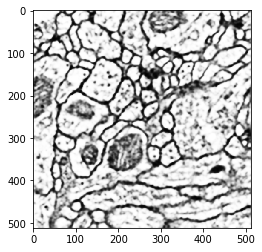

In [23]:
plt.imshow(np.reshape(res[0]*255, IMG_SIZE), cmap='gray')

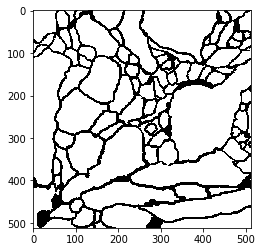

In [24]:
plt.imshow(np.reshape(train_label[0]*255, IMG_SIZE), cmap='gray')

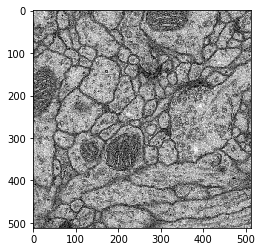

In [25]:
plt.imshow(np.reshape(train_data[0]*255, IMG_SIZE), cmap='gray')